# Djikstra Mining Algorithm
## Problem Statement

A ship has a start position at time t=0, which we will call Point P. It must deliver its cargo to a shipyard at time t=t_max. What moves should it take that will deposit the maximum halite to a shipyard?

## Algorithm
Djikstra's algorithm is similar to a breadth-first search that can bail out of subsolutions that are clearly not optimal. It exploits a few features of our solution space. Namely that the best path from point P to point Q that goes through R MUST include the best path from R to Q. This allows us to find the best path between all neighbors of known best solutions.

A* would be lovely to use, but we don't have any way of knowing which actions will lead us toward the best solution so Djikstra's is the next best thing.

Another thing that can make Djiktra's particularly efficient is if we can quickly score a neighboring solution to a solution with a known score. We use the fact that adding movement to a solution doesn't change the score. So most of the neighboring solutions don't even need to be scored again.

## Description

We start out by assigning empty solutions for our destinations at t=0 

Every iteration we look at the best solution we found for our neighbors for t-1 as well as our current solution with an additional action of mining. One of those 5 solutions is the best solution for this position at t.

This algorithm should work fine for multiple destinations, but will only work fine for multiple start positions if you are lucky enough that all routes you find don't share any mining destinations or occupy the same position at the same time.

This is guaranteed to find the best mining route for one ship but is NOT guaranteed to find the global maximum for all ships. Which is probably acceptable. Simultaneously finding routes for all ships is possible but a little complicated to write.

## Variants

### Forward Solving
This approach solves for the solution from the destination to the source which is a little backwards, but it means that each solution is valid if a hypothetical ship was at that location. Instead you could solve it forwards meaning that the solution is valid if a hypothetical destination was at that location.

### Sparse Matrix
Right now we consider this a dense matrix meaning that potentially all squares are minable, but it may be that this could be considered a sparse matrix and it only makes sense to mine on a small number of cells. In that case, we'd want to represent it as a graph instead of a lattice. Solutions would be much more compact because intermediate destinations in between mining locations are irrelevant. I think it would be more complicated to write but it may turn out to be more efficient.
 
## Extensions
Right now we take the first, highest scoring path we find. Instead we could collect all high scoring paths we find. This would give us a collection of equivalent scoring paths to choose based on other criteria (ship congestion, hazards, etc). This wouldn't add to the runtime complexity. Just extra bookkeeping.

This cell just sets up the initial board so we have an interesting problem to look at.

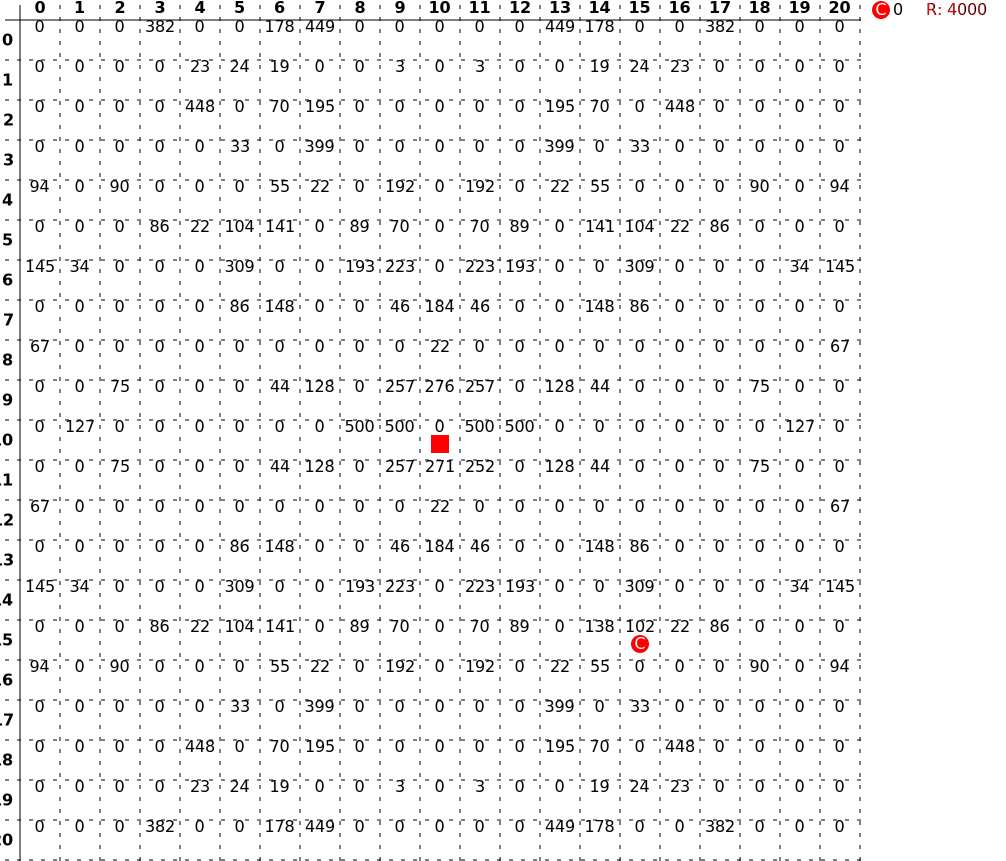

In [197]:
from kaggle_environments import make
from kaggle_environments.envs.halite.helpers import *
from board_viz import draw_board
board_size = 21
environment = make("halite", configuration={"size": board_size})
agent_count = 1
environment.reset(agent_count)
state = environment.state[0]
board = Board(state.observation, environment.configuration)
s = list(board.ships.values())[0]
s.next_action = ShipAction.CONVERT
board = board.next()
sy = list(board.shipyards.values())[0]
sy.next_action = ShipyardAction.SPAWN
board = board.next()
for _ in range(5):
    s = list(board.ships.values())[0]
    s.next_action = ShipAction.NORTH
    board = board.next()
    s = list(board.ships.values())[0]
    s.next_action = ShipAction.EAST
    board = board.next()

draw_board(board)

Now we use this board to calculate the best routes for every square on the board up to 15 turns away.

In [198]:
from dataclasses import dataclass
import numpy as np
from itertools import product
import time

# action names
NORTH = 'N'
SOUTH = 'S'
EAST = 'E'
WEST = 'W'
MINE = 'M'

@dataclass
class Action:
    to_point: Point
    action: str

# actions and where they come from
possible_actions = [
    Action(Point(0, 0), MINE),
    Action(Point(1, 0), WEST),
    Action(Point(-1, 0), EAST), 
    # North and south are backward
    Action(Point(0, 1), SOUTH), 
    Action(Point(0, -1), NORTH)
]

@dataclass
class Route:
    # path is a str of concatenated action names
    path: str
    # expected amount of halite gained from this route
    value: int

# where an action would take you
dir_lookup = {
    EAST: Point(1, 0),
    WEST: Point(-1, 0),
    # north and south are backward
    NORTH: Point(0,1),
    SOUTH: Point(0,-1),
    MINE: Point(0, 0)
}

def detect_cycle(path):
    ''' Have we been to the current position before? '''
    curr_pos = Point(0, 0)
    covered = set()
    prev_pos = None
    for p in path[-1::-1]:
        curr_pos += dir_lookup[p]
        if curr_pos != prev_pos:
            covered.add(prev_pos)
        prev_pos = curr_pos
    return curr_pos in covered

def score_path(path: str, start_point: Point, board: Board, prev_score: float):
    ''' find the expected score from path
    path is a str of concatenated action names
    prev_score is the score for path[1:]
    This assumes all mining of the same square is consecutive
    '''
    if path[0] != MINE:
        return prev_score
    point_halite = board.cells[start_point].halite
    for c in path[1:]:
        if c != MINE:
            break
        point_halite *= 0.75
    return point_halite * 0.25 + prev_score

def find_best_paths(board, board_size, t_max, targets, time_max):
    # m is a matrix of starting point to best route to a dest
    # (or alternatively dest point to best route to a start)
    m = np.full((board_size, board_size), None)
    # set destinations as empty solution
    for target in targets:
        m[target.x, target.y] = Route('', 0)
    # these are the next values for m
    m_next = np.full((board_size, board_size), None)
    for t in range(1, t_max + 1):
        for pos in product(range(board_size), repeat=2):
            if time.time() > time_max:
                return m
            # if there was a path to dest from here @ t-1...
            if m[pos] is not None:
                # then there must be a viable path to all of my neighbors @ t
                for possible in possible_actions:
                    # p is the neighbor of pos
                    p = (Point(*pos) + possible.to_point) % board_size
                    # the path that adds p to the best route of pos
                    ppath = possible.action + m[pos].path
                    # no mining somewhere we've already been
                    if detect_cycle(ppath) and possible.action == MINE:
                        continue
                    # The expected score if we follow this route
                    p_score = score_path(ppath, p, board, m[pos].value)
                    # we have found the first path for p or we have found a better path for p
                    if m_next[p.x, p.y] is None or p_score > m_next[p.x, p.y].value:
                        m_next[p.x, p.y] = Route(ppath, p_score)
        m = m_next
        m_next = np.full((board_size, board_size), None)
    return m

t_max = 20
time_max = 3.0
targets = [shipyard.position for shipyard in board.shipyards.values()]
start_time = time.time()
solutions = find_best_paths(board, board_size, t_max, targets, start_time + time_max)
end_time = time.time()
print(f'solution found in: {end_time - start_time} seconds')
print(f't_max: {len(solutions[targets[0]].path)}')

solution found in: 2.8541815280914307 seconds
t_max: 20


In [199]:
friendly_names = {
    'N': 'North',
    'S': 'South',
    'E': 'East',
    'W': 'West'
}
mining_locs = []
ship_pos = list(board.ships.values())[0].position
dest = list(board.shipyards.values())[0].position
print('start pos:', ship_pos, 'destination:', dest)
route = solutions[ship_pos.y, ship_pos.x]
curr_pos = ship_pos
for p in route.path:
    if p == MINE:
        print('Mine')
        continue
    mining_locs.append(curr_pos)
    curr_pos = (dir_lookup[p]+curr_pos)%board_size
    print(f'head {friendly_names[p]} to {curr_pos}')
print('expected halite:', route.value)

start pos: (15, 15) destination: (10, 10)
head South to (15, 14)
Mine
head West to (14, 14)
head West to (13, 14)
head West to (12, 14)
Mine
Mine
Mine
Mine
head South to (12, 13)
head South to (12, 12)
head South to (12, 11)
head South to (12, 10)
Mine
Mine
Mine
Mine
head West to (11, 10)
Mine
head West to (10, 10)
expected halite: 675.9392265624999


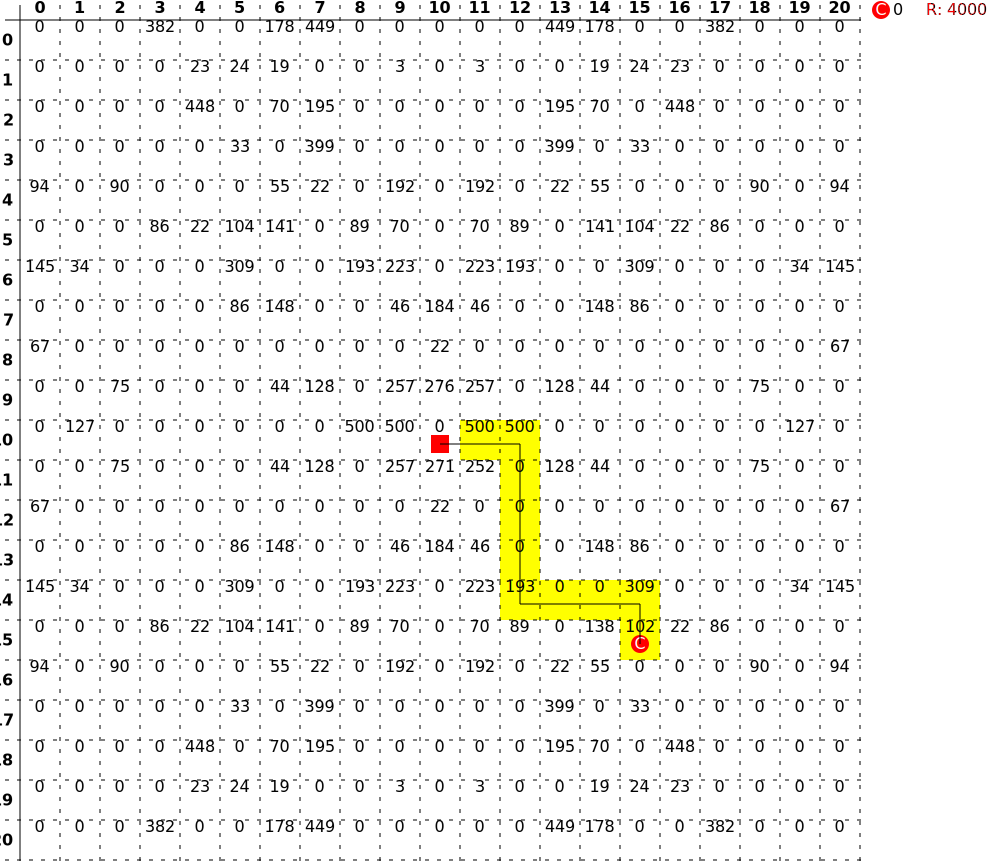

In [200]:
draw_board(board, highlights=mining_locs, sequence=mining_locs+[curr_pos])